# Linear Models with CNN

In [7]:
%matplotlib inline
import utils; reload(utils)
from utils import *

### How to learn Cats/Dogs model from ImageNet 1000
Method 1: find larget prob of either a cat or a dog. compare
the avg prob of all the cat categories and compare them to average
dog categories

Cons : they need manual coding - we are directing them to learn something from teh data
. Also they ignore some information in the earlier predictions like dog is more likely to be with a bone then a cat
Solution : Learn a Linear Model that is trained using 1000 Imagenet predictions for each image as input and dog/cat as output

In [11]:
%matplotlib inline
from __future__ import division, print_function
import os, json
# directory and file processing library
from glob import glob
# python does not have arrays - basic math helper library
import numpy as np
# science library for python
import scipy
# standard machine learning library
from sklearn.preprocessing import OneHotEncoder
# confusion matrix - to graph actual value and prediction difference
from sklearn.metrics import confusion_matrix 
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import plots, get_batches, plot_confusion_matrix, get_data
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

In [14]:
import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

## Working with Simple Linear Model
Dense Layer : Linear Model followed by a activation function like sigmoid, ReLU or tanh
Example of Simple Linear Model using Keras

In [15]:
x = random((30,2))
y = np.dot(x, [2, 3]) + 1

In [16]:
x[:5]

array([[ 0.4634,  0.7114],
       [ 0.86  ,  0.8207],
       [ 0.8806,  0.3463],
       [ 0.3647,  0.2683],
       [ 0.5483,  0.5407]])

In [17]:
y[:5]

array([ 4.0611,  5.182 ,  3.8002,  2.5343,  3.7187])

In [19]:
# use keras to create a simple linear model
# no activation function as linear model and simple SGD optimization
# to minimize MSE - mean squared error
lm = Sequential([Dense(1, input_shape=(2,))])
lm.compile(optimizer=SGD(lr=0.1), loss='mse')

In [20]:
# calcuate the prediction with initial weights
# intitial weight variance is defined by Xavier Initialization
# variance(Weights) = 2 / (n_input + n_output)
lm.evaluate(x, y, verbose=0)

12.670784950256348

In [22]:
# perform actual training for 5 epochs
lm.fit(x, y, nb_epoch=5, batch_size=1)

Epoch 1/5
30/30 [==============================] - 0s - loss: 1.1038     
Epoch 2/5
30/30 [==============================] - 0s - loss: 0.1563     
Epoch 3/5
30/30 [==============================] - 0s - loss: 0.0802     
Epoch 4/5
30/30 [==============================] - 0s - loss: 0.0368     
Epoch 5/5
30/30 [==============================] - 0s - loss: 0.0181     


In [23]:
lm.evaluate(x, y, verbose=0)

0.015208890661597252

In [24]:
lm.get_weights()

[array([[ 1.8051],
        [ 2.6649]], dtype=float32), array([ 1.2058], dtype=float32)]

In [27]:
??keras.layer.get_weights

Object `keras.layer.get_weights` not found.


In [29]:
path = "../../data/dogscats/sample/"
model_path = path + 'models/'
if not os.path.exists(model_path) : os.mkdir(model_path)

In [30]:
# batch_size = 100
batch_size = 4

In [31]:
from vgg16 import Vgg16
vgg = Vgg16()
# get pretrained model
model = vgg.model

32768/35363 [==========================>...] - ETA: 0s

Overall approach:
1. get true labels for every image
2. get 1000 imagenet categories predictions for every image
3. feed the predictions as input to simple linear model

In [34]:
??vgg.model

In [35]:
val_batches = get_batches(path+'valid', shuffle=False, batch_size=1)
batches = get_batches(path+'train', shuffle=False, batch_size=1)

Found 40 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


We do not need to load and store images every time we want to use them.
we can save them as processed arrays - numpy arrays
saving numpy array in python - 1. hdf5 format to store the numpy array
2. bcolz 

In [36]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname) : return bcolz.open(fname)[:]

In [37]:
??get_data

In [38]:
val_data = get_data(path+'valid')
trn_data = get_data(path+'train')

Found 40 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [39]:
# (no_of_images, channels, height, wight) - due to theano backend
trn_data.shape

(160, 3, 224, 224)

In [40]:
val_data.shape

(40, 3, 224, 224)

In [41]:
# store the complete input training images and validation image array
save_array(model_path+'train_data.bc', trn_data)
save_array(model_path+'valid_data.bc', val_data)

In [42]:
trn_data = load_array(model_path+'train_data.bc')
val_data = load_array(model_path+'valid_data.bc')

In [43]:
trn_data.shape

(160, 3, 224, 224)

In [44]:
val_data.shape

(40, 3, 224, 224)

In [45]:
# Keras return classes for each image as number thus a single cols
# need to conver the column to one hot encoding
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [49]:
val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)
trn_labels.shape

(160, 2)

In [50]:
# this 1000 imagenet probs will from VGG (Visual Geometry Group) - will be input features for
# our linear model

In [51]:
trn_features = model.predict(trn_data, batch_size=batch_size)
val_features = model.predict(val_data, batch_size=batch_size)

In [52]:
trn_features.shape

(160, 1000)

In [55]:
save_array(model_path+'train_lastlayer_features.bc', trn_features)
save_array(model_path+'valid_lastlayer_features.bc', val_features)

In [56]:
trn_features = load_array(model_path+'train_lastlayer_features.bc')
val_features = load_array(model_path+'valid_lastlayer_features.bc')

In [57]:
## Now Simply define the linear model using saved features and 2 output
lm = Sequential([ Dense(2, activation='softmax', input_shape=(1000,)) ])
lm.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [65]:
batch_size = 4
lm.fit(trn_features, trn_labels, 3, batch_size, validation_data=(val_features, val_labels))

Train on 160 samples, validate on 40 samples
Epoch 1/4
160/160 [==============================] - 0s - loss: 0.2146 - acc: 0.9438 - val_loss: 0.0867 - val_acc: 1.0000
Epoch 2/4
160/160 [==============================] - 0s - loss: 0.0764 - acc: 0.9875 - val_loss: 0.0421 - val_acc: 1.0000
Epoch 3/4
160/160 [==============================] - 0s - loss: 0.0416 - acc: 0.9875 - val_loss: 0.0333 - val_acc: 1.0000
Epoch 4/4
160/160 [==============================] - 0s - loss: 0.0276 - acc: 0.9875 - val_loss: 0.0259 - val_acc: 1.0000


In [66]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_6 (Dense)                  (None, 2)             2002        dense_input_2[0][0]              
Total params: 2002
____________________________________________________________________________________________________


In [67]:
preds = lm.predict_classes(val_features, batch_size=batch_size)

 4/40 [==>...........................] - ETA: 0s

In [68]:
probs = lm.predict_proba(val_features, batch_size=batch_size)[:,0]

 4/40 [==>...........................] - ETA: 0s

In [69]:
probs[:8]

array([ 1.    ,  1.    ,  1.    ,  0.9788,  0.9999,  1.    ,  0.9997,  0.9999], dtype=float32)

In [70]:
filenames = val_batches.filenames

In [80]:
n_view = 4
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)

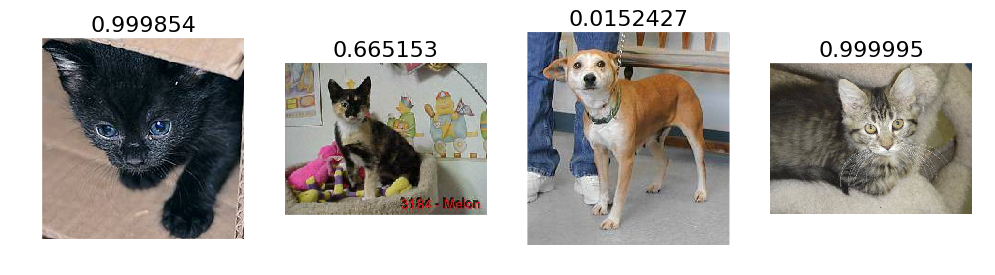

In [92]:
correct = np.where(preds==val_labels[:,1])[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

In [97]:
#2. A few incorrect labels at random
incorrect = np.where(preds!=val_labels[:,1])[0]
if len(incorrect):
    idx = permutation(incorrect)[:n_view]
    plots_idx(idx, probs[idx])
else:
    print('No incorrect labels')

No incorrect labels


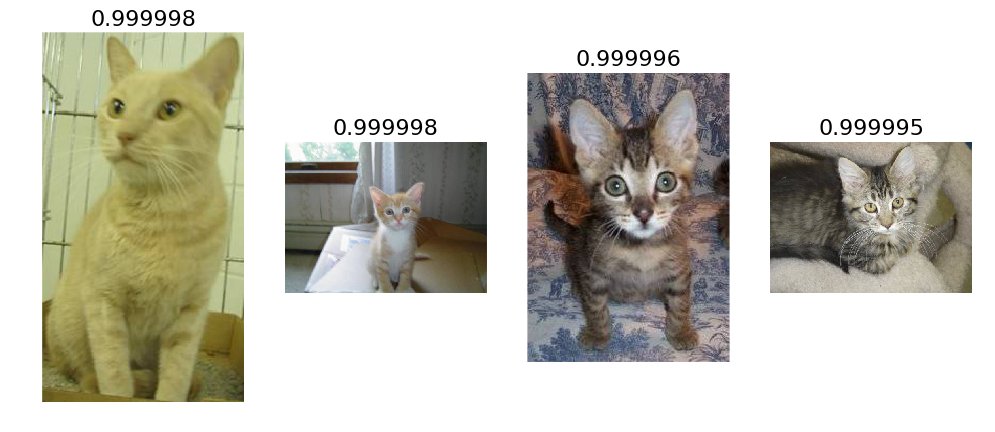

In [89]:
#3. The images we most confident were cats, and are actually cats
correct_cats = np.where((preds==0) & (preds==val_labels[:,1]))[0]
most_correct_cats = np.argsort(probs[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], probs[correct_cats][most_correct_cats])

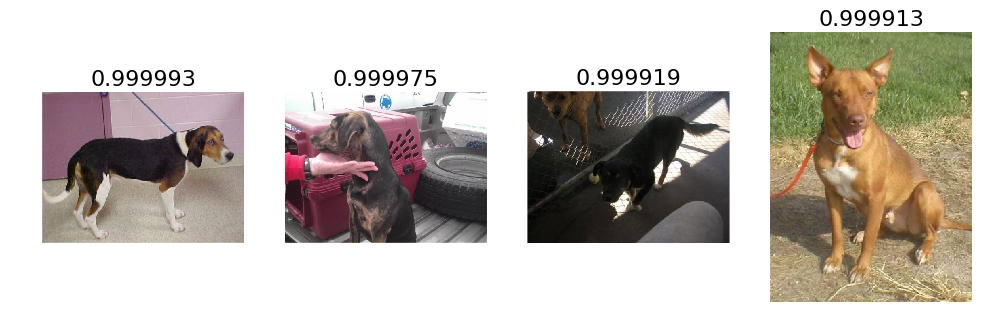

In [94]:
# as above, but dogs
correct_dogs = np.where((preds==1) & (preds==val_labels[:,1]))[0]
most_correct_dogs = np.argsort(probs[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], 1-probs[correct_dogs][most_correct_dogs])

In [98]:
#3. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((preds==0) & (preds!=val_labels[:,1]))[0]
most_incorrect_cats = np.argsort(probs[incorrect_cats])[::-1][:n_view]
# for cats the probs will be closer to 1
if len(most_incorrect_cats):
    plots_idx(incorrect_cats[most_incorrect_cats], probs[incorrect_cats][most_incorrect_cats])
else:
    print('No incorrect cats!')

No incorrect cats!


In [99]:
#3. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((preds==1) & (preds!=val_labels[:,1]))[0]
most_incorrect_dogs = np.argsort(probs[incorrect_dogs])[:n_view]
if len(most_incorrect_dogs):
    plots_idx(incorrect_dogs[most_incorrect_dogs], 1-probs[incorrect_dogs][most_incorrect_dogs])
else:
    print('No incorrect dogs!')

No incorrect dogs!


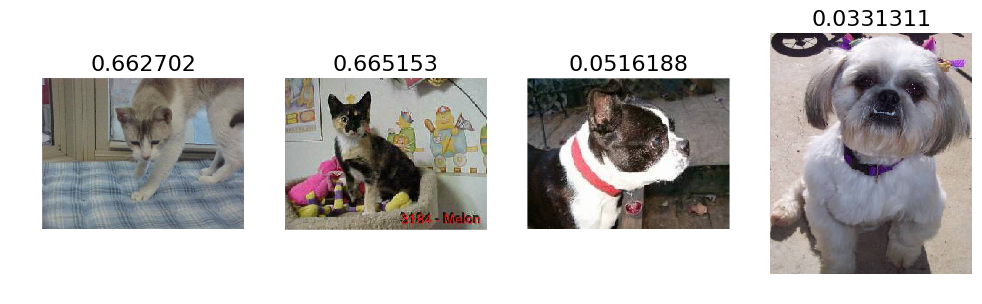

In [100]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(probs-0.5))
plots_idx(most_uncertain[:n_view], probs[most_uncertain])

## Confusion Matrix
Best way to analyze the result of classification model is to use classification matrix

In [101]:
cm = confusion_matrix(val_classes, preds)

In [102]:
val_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [103]:
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

[[20  0]
 [ 0 20]]


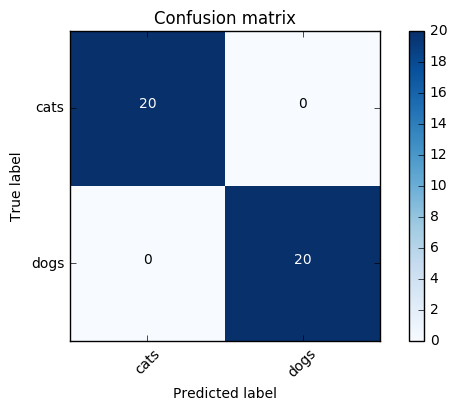

In [104]:
plot_confusion_matrix(cm , val_batches.class_indices)

## Activation Function and Why we need them
All deep model layers have activation functions, as when we stack the linear models
we end up with the linear model - 
Concept or crux of neural networks - they are machine which can learn any arbitary function
- in terms of million of paramters - can model anything - thats why
they are exciting - with activation layer - we introduce non linearlity - which 
allows neural networks to learn any complex arbitary function.

Its an extra ordinary insights - that with this simple stacking of linear and non linear layers we are learn anything --- :-). we can model anything. This theorem is called
Universal Approximation Theorem

Activation function for the last layer - it has to be different - as it cater 
to a particular problem. if the output is one hot encoded categorial variable - output prob should add to 1 - and a single activation much higher than the rest - as with one hot encoing 
we have single 1 and all 0's. Thus we will introduce the activation function
with a certain characteristics: called Softmax Function
Softmax = exp(x[i]) /sum(exp(x)) - with 1, we will have larger values

## Approch2 : Retrain the last layer's Linear Model

Since VGG16 layer is Dense (linear model) - its does not make sense to add an extra linear layer
on top of it - also last layer already has softmax function implemented. by adding 
another layer - we will have softmax function in intermediate layer - which is odd
Approach: Remove the last layer and replace it with one we train for distinguishing 
between dogs and cats
How to do it:
1. remove last layers
2. tell keras to we want to fix weights of all the other layers
3. learn the new Dense Layer

In [105]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [106]:
model.pop()

In [107]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [108]:
for layer in model.layers: layer.trainable=False

In [110]:
# as now we have modified the model, should not run the code in 
# in previous section
model.add(Dense(2, activation='softmax'))

In [113]:
# need to compile the updated model and set up batches
gen = image.ImageDataGenerator()
batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=True)

In [127]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.N, nb_epoch=nb_epoch,
                       validation_data=val_batches, nb_val_samples=val_batches.N)

In [121]:
batches

In [128]:
opt = RMSprop(lr=0.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [129]:
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/2
160/160 [==============================] - 54s - loss: 5.1434 - acc: 0.6687 - val_loss: 1.2089 - val_acc: 0.9250
Epoch 2/2
160/160 [==============================] - 54s - loss: 1.1334 - acc: 0.9250 - val_loss: 2.5419 - val_acc: 0.8250


In [130]:
model.save_weights(model_path+'finetune1.h5')
model.load_weights(model_path+'finetune1.h5')
model.evaluate(val_data, val_labels)
preds = model.predict_classes(val_data, batch_size=batch_size)
probs = model.predict_proba(val_data, batch_size=batch_size)[:,0]
probs[:8]
cm = confusion_matrix(val_classes, preds)

40/40 [==============================] - 11s    


## Retraining more layers in 
Its better to retrain or fine tune all the dense layers
How can we retrain multiple dense ??
### Motivation for back -propagation
backprop - simply calculating the gradient using chain rule
Z = f(g(x)) 
Z' = dZ/dx = d/dx(f(g(x)) = df/dg * dg/dx = f' * g'
Key Insight : By stacking up linear and non linear activations - we simply
have function of functions (of function, of function). each layer is
taking the output of previos layer and using it as input to its function
thus, derivative at a layer = gradient of the layer * gradient of the following layers
The use of the chain rule to calculate the derivative of the model is called backprop
Keras, tensorflow, theano does automatic Backprop to calculate teh gradient 
of any layer

## Training multiple layers in Keras
Code below will work for any model that contains the dense layers.
With the new learning function - need to fine tune ther final layer - to avoid
having the random weights - this weights will cause the other layers to move
away from the optimized imagenet weights

In [136]:
layers = model.layers
# Get the index of the first dense layer
first_dense_idx = [index for index, layer in enumerate(layers)]

38

In [ ]:
# set this layer and all subsequent layers to be trainable
for layer in layers[first_dense_idx:]: layer.trainable = True

In [137]:
# as we have not changed our architecture, we do not need to recompile
# change the learning rate, set lower learning rate
K.set_value(opt.lr,0.01)
# use the backend variable K
fit_model(model, batches, val_batches, 3)

Epoch 1/3
160/160 [==============================] - 54s - loss: 3.1140 - acc: 0.8000 - val_loss: 1.6118 - val_acc: 0.9000
Epoch 2/3
160/160 [==============================] - 55s - loss: 1.5435 - acc: 0.9000 - val_loss: 1.2089 - val_acc: 0.9250
Epoch 3/3
160/160 [==============================] - 55s - loss: 1.0709 - acc: 0.9312 - val_loss: 1.2089 - val_acc: 0.9250


In [138]:
model.save_weights(model_path+'finetune2.h5')

In [139]:
??model.save_weights

We have fined tuned all teh dense layers in the model, we already 
have finetuned the last layer first and then fine tune all the remaining 
dense layer.
as we are learning natural images, we an retrain few convolution layers as well

In [ ]:
for layer in layers[12:]: layer.trainable=True
K.set_value(opt.lr, 0.001)
fit_model(model, batches, val_batches, 1)

Epoch 1/1
120/160 [=====================>........] - ETA: 10s - loss: 1.2089 - acc: 0.9250

In [ ]:
model.save_weights(model_path+'finetune3.h5')

In [ ]:
model.load_weights(model_path+'finetune2.h5')
model.evaluate_generator(get_batches(path+'valid', gen, False, batch_size*2), val_batches.N)